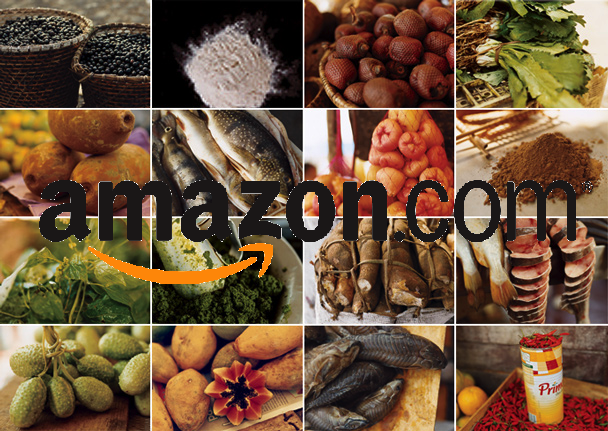

In [3]:
from IPython.display import Image
img = r'C:\Users\Lenovo\Desktop\AAIC\NewCover.png'
Image(img)

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

#### Excerpt:
We are using KNN algorithm both with brute force and kd-tree approach.k-fold cross validation gives us best k and ROC and Confusion matrix tells us how good the classifier is.



# NOTE: 
i choosed 20k data points as the system was not responding with higher number of points in dataset



# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os



E:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
final =final.sample(100000)

final['Score'].value_counts()



1    84374
0    15626
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)



If you research, organic, unrefined cold pressed extra virgin coconut oil, you will see that it is a medium chain triglyceride. This means that it goes straight to the liver to be stored for energy. It doesn't go into the bloodstream, where it can break off & deposit in the arteries in the form of plaque.<br />Coconut oil is a clear liquid at 76 degrees. Your body, being 98.6, keeps it in a clear liquid state, so it cannot solidify in the body as butters or margarines do.<br />Coconut and avocado oils are healthy fats that have been maligned for years. This is a con game just to get more people on to cholesterol lowering drugs.<br />It's subtle coconut flavor and high smoking point make it very useful in cooking and baking. Olive oil now only gets used for quick sauteing and salads. Butter now gets used very sparingly as well. We use mashed avocado or coconut oil in baked potato instead of globs of butter.<br />My husband uses it on his hair and skin as a moisturizer.<br />My only disa

In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)

print(sent_0)

If you research, organic, unrefined cold pressed extra virgin coconut oil, you will see that it is a medium chain triglyceride. This means that it goes straight to the liver to be stored for energy. It doesn't go into the bloodstream, where it can break off & deposit in the arteries in the form of plaque.<br />Coconut oil is a clear liquid at 76 degrees. Your body, being 98.6, keeps it in a clear liquid state, so it cannot solidify in the body as butters or margarines do.<br />Coconut and avocado oils are healthy fats that have been maligned for years. This is a con game just to get more people on to cholesterol lowering drugs.<br />It's subtle coconut flavor and high smoking point make it very useful in cooking and baking. Olive oil now only gets used for quick sauteing and salads. Butter now gets used very sparingly as well. We use mashed avocado or coconut oil in baked potato instead of globs of butter.<br />My husband uses it on his hair and skin as a moisturizer.<br />My only disa

In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)



If you research, organic, unrefined cold pressed extra virgin coconut oil, you will see that it is a medium chain triglyceride. This means that it goes straight to the liver to be stored for energy. It doesn't go into the bloodstream, where it can break off & deposit in the arteries in the form of plaque.Coconut oil is a clear liquid at 76 degrees. Your body, being 98.6, keeps it in a clear liquid state, so it cannot solidify in the body as butters or margarines do.Coconut and avocado oils are healthy fats that have been maligned for years. This is a con game just to get more people on to cholesterol lowering drugs.It's subtle coconut flavor and high smoking point make it very useful in cooking and baking. Olive oil now only gets used for quick sauteing and salads. Butter now gets used very sparingly as well. We use mashed avocado or coconut oil in baked potato instead of globs of butter.My husband uses it on his hair and skin as a moisturizer.My only disapointment is that Nutiva does 

In [20]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_0 = decontracted(sent_0)
print(sent_0)
print("="*50)

If you research, organic, unrefined cold pressed extra virgin coconut oil, you will see that it is a medium chain triglyceride. This means that it goes straight to the liver to be stored for energy. It does not go into the bloodstream, where it can break off & deposit in the arteries in the form of plaque.<br />Coconut oil is a clear liquid at 76 degrees. Your body, being 98.6, keeps it in a clear liquid state, so it cannot solidify in the body as butters or margarines do.<br />Coconut and avocado oils are healthy fats that have been maligned for years. This is a con game just to get more people on to cholesterol lowering drugs.<br />It is subtle coconut flavor and high smoking point make it very useful in cooking and baking. Olive oil now only gets used for quick sauteing and salads. Butter now gets used very sparingly as well. We use mashed avocado or coconut oil in baked potato instead of globs of butter.<br />My husband uses it on his hair and skin as a moisturizer.<br />My only di

In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

If you research, organic, unrefined cold pressed extra virgin coconut oil, you will see that it is a medium chain triglyceride. This means that it goes straight to the liver to be stored for energy. It does not go into the bloodstream, where it can break off & deposit in the arteries in the form of plaque.<br />Coconut oil is a clear liquid at  degrees. Your body, being  keeps it in a clear liquid state, so it cannot solidify in the body as butters or margarines do.<br />Coconut and avocado oils are healthy fats that have been maligned for years. This is a con game just to get more people on to cholesterol lowering drugs.<br />It is subtle coconut flavor and high smoking point make it very useful in cooking and baking. Olive oil now only gets used for quick sauteing and salads. Butter now gets used very sparingly as well. We use mashed avocado or coconut oil in baked potato instead of globs of butter.<br />My husband uses it on his hair and skin as a moisturizer.<br />My only disapoint

In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:42<00:00, 2379.44it/s]


In [25]:
for i in range(8):
    print(preprocessed_reviews[i])
    print("*"*30)

research organic unrefined cold pressed extra virgin coconut oil see medium chain triglyceride means goes straight liver stored energy not go bloodstream break deposit arteries form plaque coconut oil clear liquid degrees body keeps clear liquid state cannot solidify body butters margarines coconut avocado oils healthy fats maligned years con game get people cholesterol lowering drugs subtle coconut flavor high smoking point make useful cooking baking olive oil gets used quick sauteing salads butter gets used sparingly well use mashed avocado coconut oil baked potato instead globs butter husband uses hair skin moisturizer disapointment nutiva not use glass jars instead plastic give body break try nutiva coconut oil
******************************
delicious hot cold impressive tasting herbal tea ever tasted love hot winter cold summer like mix double strength cold tea got delightful flavor
******************************
son started product organic foods vegetarian start path tell one thi

# 4. APPLYING KNN

In [59]:
#importing all modules from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

# 4.A Splitting the data 

In [60]:
#to avoid data leakage we are splitting the data prior to vectorizing it 
X_in,X_test,Y_in,Y_test = train_test_split(preprocessed_reviews,final['Score'],test_size = 0.2,random_state = 0)
X_train,X_cv,Y_train,Y_cv  = train_test_split(X_in,Y_in,test_size=0.2)
print('training dataset has {} number of data points'.format(len(Y_train)))
print('validation dataset has {} number of data points'.format(len(Y_cv)))
print('test dataset has {} number of data points'.format(len(Y_test)))

training dataset has 64000 number of data points
validation dataset has 16000 number of data points
test dataset has 20000 number of data points


# 4.1 Bag of vectors 

# featurization

In [28]:
#applying bag of vectors on all three datasets
count_vect  = CountVectorizer()
final_train_counts = count_vect.fit_transform(X_in)
test_counts = count_vect.transform(X_test)
train_counts = count_vect.fit_transform(X_train)
cv_counts = count_vect.transform(X_cv)
#test_counts = count_vect.transform(X_test)
print(final_train_counts.shape)
print(train_counts.shape)
print(test_counts.shape)
print(cv_counts.shape)


(80000, 54228)
(64000, 48776)
(20000, 54228)
(16000, 48776)


 # 4.1.1 Implementing KNN using brute force

#  Simple cross validation

In [43]:



neighbors = [i for i in range(1,30,2)]
train_auc = []
cv_auc = []



for i in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_counts,Y_train)
    pred_tr = []
    for i in range(0,train_counts.shape[0],1000): #doing bactch wise prediction
        pred_tr.append(knn.predict_proba(train_counts[i:i+1000])[:,1])#predicting on chunks of 1000 data points each time
    pred_cv = []
    for j in range(0,cv_counts.shape[0],1000):
        pred_cv.append(knn.predict_proba(cv_counts[j:j+1000])[:,1])
    train_auc.append(roc_auc_score(Y_train,np.hstack(pred_tr)))
    cv_auc.append(roc_auc_score(Y_cv,np.hstack(pred_cv)))
   

                  





100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [3:35:21<00:00, 224.46s/it]


# best hyperparameter

best hyperparameter is 25 giving  auc of 0.6952958478500697 on cv data


Text(0.5,1,'AUC vs k')

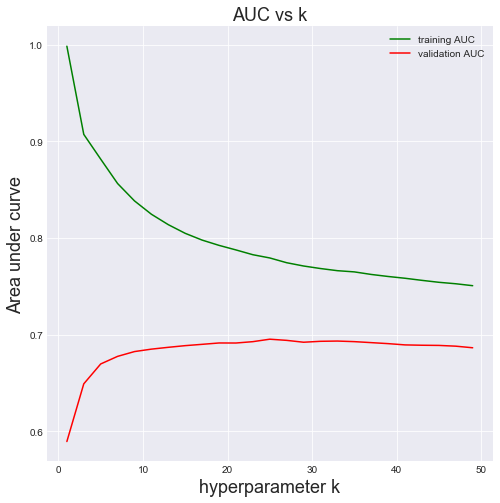

In [45]:
auc_max = max(cv_auc)
optimal_k = neighbors[cv_auc.index(auc_max)]
print('best hyperparameter is {} giving  auc of {} on cv data'.format(optimal_k,auc_max))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors,train_auc,'g',label = 'training AUC')
plt.plot(neighbors,cv_auc,'r',label='validation AUC')

plt.xlabel('hyperparameter k',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs k',fontsize=18)


best hyperparameter is found by considering highest auc score on cross validation dataset

#  AUC score

In [46]:
print("*"*50)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn_optimal.fit(final_train_counts,Y_in)
pred = knn_optimal.predict(test_counts)
pred_train = []
pred_test = []
for i in range(0,final_train_counts.shape[0],1000):
    pred_train.append(knn_optimal.predict_proba(final_train_counts[i:i+1000])[:,1])
train_proba = np.hstack(pred_train)
for j in range(0,test_counts.shape[0],1000):
    pred_test.append(knn_optimal.predict_proba(test_counts[j:j+1000])[:,1])
test_proba = np.hstack(pred_test)
test_auc_brute_bow = roc_auc_score(Y_test,test_proba)
print('AUC on test data of knn classifier for k = {} is {}'.format(optimal_k,test_auc_brute_bow))

bow_brute_k = optimal_k

**************************************************
AUC on test data of knn classifier for k = 25 is 0.7011771868031555


we are training the data with best hyperparameter and find the AUC on test data with it

# ROC Curve

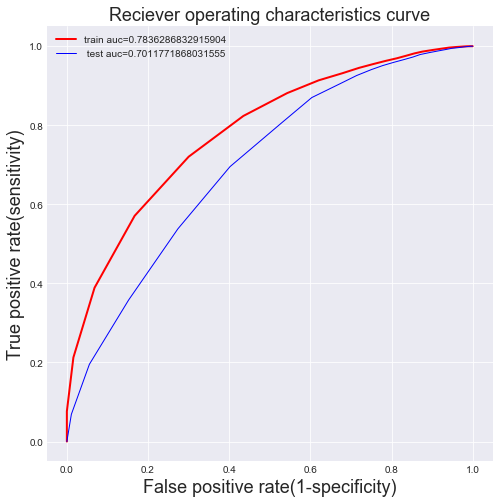

In [47]:
#plotting the ROC




fpr_tr, tpr_tr, _ = roc_curve(Y_in,train_proba)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_proba)
auc_train = roc_auc_score(Y_in,train_proba)
auc_test = roc_auc_score(Y_test, test_proba)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))

plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()








# Confusion matrix

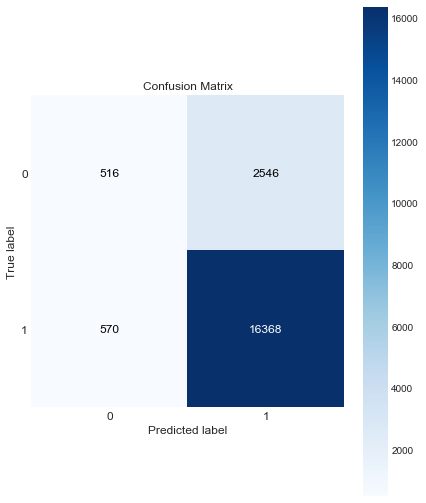

In [48]:
import scikitplot.metrics as skplt#using scikit-plot to directly get confusion matrix
skplt.plot_confusion_matrix(Y_test,pred,normalize=False,figsize=(7,9),text_fontsize='large')

# 4.1.2 Implementing KNN using Kd-tree

In [56]:
count_vect = CountVectorizer(min_df=10, max_features=500)#applying bag of vectors on all three datasets with limit to maximum features
#considering 40k datapoints for kd_tree
final_train_counts = count_vect.fit_transform(X_in).todense()[0:32000]
test_counts = count_vect.transform(X_test).todense()[0:8000]
train_counts = count_vect.fit_transform(X_train).todense()[0:25600]
cv_counts  =count_vect.transform(X_cv).todense()[0:6400]

print(cv_counts.shape)
print(train_counts.shape)
print(final_train_counts.shape)
print(test_counts.shape)


(6400, 500)
(25600, 500)
(32000, 500)
(8000, 500)


# Simple Cross validation

In [58]:
#**************************************4 fold cross validation********************************
neighbors = [i for i in range(1,30,2)]
train_auc = []
cv_auc = []



for i in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(train_counts,Y_train[0:25600])
    pred_tr = []
    for i in range(0,train_counts.shape[0],1600):
        pred_tr.append(knn.predict_proba(train_counts[i:i+1600])[:,1])
    pred_cv = []
    for j in range(0,cv_counts.shape[0],800):
        pred_cv.append(knn.predict_proba(cv_counts[j:j+800])[:,1])
    train_auc.append(roc_auc_score(Y_train[0:25600],np.hstack(pred_tr)))
    cv_auc.append(roc_auc_score(Y_cv[0:6400],np.hstack(pred_cv)))
    




  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


  7%|█████▎                                                                          | 1/15 [07:30<1:45:08, 450.62s/it]


 13%|██████████▋                                                                     | 2/15 [20:02<1:57:14, 541.11s/it]


 20%|████████████████                                                                | 3/15 [32:45<2:01:32, 607.69s/it]


 27%|█████████████████████▎                                                          | 4/15 [46:06<2:02:00, 665.53s/it]


 33%|██████████████████████████▋                                                     | 5/15 [59:25<1:57:36, 705.66s/it]


 40%|███████████████████████████████▏                                              | 6/15 [1:12:04<1:48:15, 721.72s/it]


 47%|████████████████████████████████████▍                                         | 7/15 [1:24:44<1:37:44, 733.01s/it]


 53%|████████████████

#   best hyperparameter

best hyperparameter is 21 giving maximum auc of 0.7405552770382822 on cv data


Text(0.5,1,'AUC vs k')

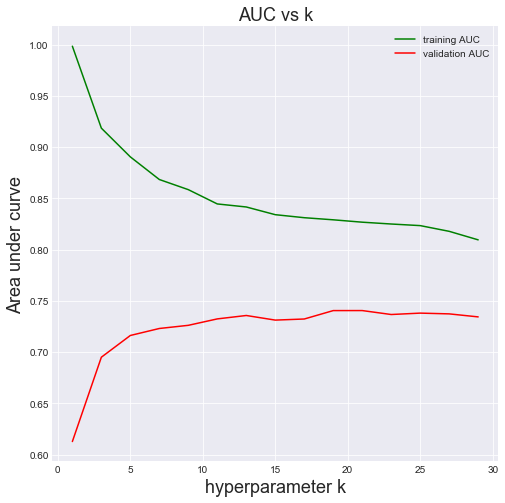

In [60]:
auc_max = max(cv_auc)
optimal_k = neighbors[cv_auc.index(auc_max)]
print('best hyperparameter is {} giving maximum auc of {} on cv data'.format(optimal_k,auc_max))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors,train_auc,'g',label = 'training AUC')
plt.plot(neighbors,cv_auc,'r',label='validation AUC')

plt.xlabel('hyperparameter k',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs k',fontsize=18)


# AUC score

In [61]:
#finding AUC on test dataset 
print("*"*50)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_optimal.fit(final_train_counts,Y_in[0:32000])
pred = knn_optimal.predict(test_counts)
pred_train = []
pred_test = []
for i in range(0,final_train_counts.shape[0],1000):
    pred_train.append(knn_optimal.predict_proba(final_train_counts[i:i+1000])[:,1])
train_proba = np.hstack(pred_train)
for j in range(0,test_counts.shape[0],1000):
    pred_test.append(knn_optimal.predict_proba(test_counts[j:j+1000])[:,1])
test_proba = np.hstack(pred_test)
test_auc_kdtree_bow = roc_auc_score(Y_test[0:8000],test_proba)
print('AUC on test data of knn classifier for k = {} is {}'.format(optimal_k,test_auc_kdtree_bow))


bow_kdtree_k = optimal_k




**************************************************
AUC on test data of knn classifier for k = 21 is 0.7599637553163726


# ROC curve

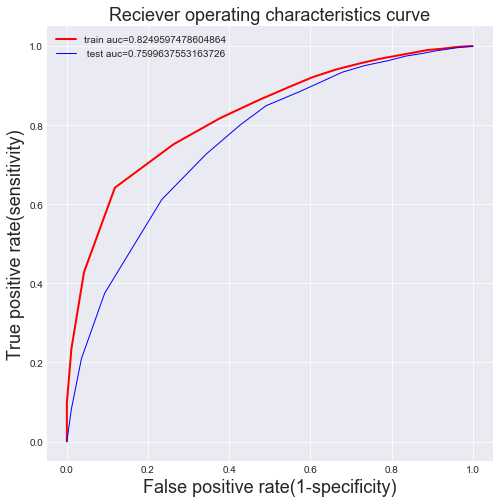

In [63]:
fpr_tr, tpr_tr, _ = roc_curve(Y_in[0:32000],train_proba)
fpr_test, tpr_test, _ = roc_curve(Y_test[0:8000],test_proba)
auc_train = roc_auc_score(Y_in[0:32000],train_proba)
auc_test = roc_auc_score(Y_test[0:8000], test_proba)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))

plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()





# Confusion matrix

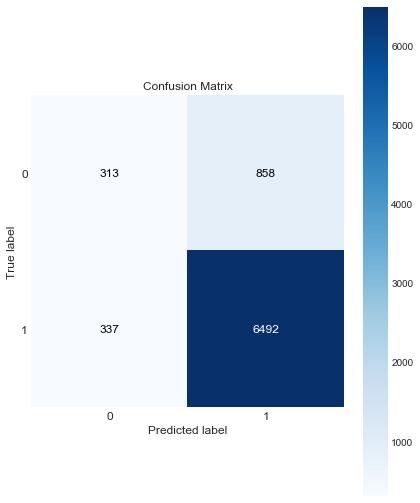

In [64]:
import scikitplot.metrics as skplt#using scikit-plot to directly get confusion matrix
skplt.plot_confusion_matrix(Y_test[0:8000],pred,normalize=False,figsize=(7,9),text_fontsize='large')

# 4.2 TF-IDF

# featurization

In [65]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_train_counts = tf_idf_vect.fit_transform(X_in)
test_counts = tf_idf_vect.transform(X_test)
cv_counts = tf_idf_vect.transform(X_cv)
train_counts = tf_idf_vect.transform(X_train)
print(final_train_counts.shape)
print(test_counts.shape)
print(cv_counts.shape)

(80000, 46785)
(20000, 46785)
(16000, 46785)


# 4.2.1 Implementing KNN using Brute force

# Simple Cross Validation

In [67]:
#*****************************************************cross validation ***********************************
neighbors = [i for i in range(1,30,2)]
train_auc = []
cv_auc = []



for i in (neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_counts,Y_train)
    pred_tr = []
    for i in range(0,train_counts.shape[0],1000): #doing bactch wise prediction
        pred_tr.append(knn.predict_proba(train_counts[i:i+1000])[:,1])#predicting on chunks of 1000 data points each time
    pred_cv = []
    for j in range(0,cv_counts.shape[0],1000):
        pred_cv.append(knn.predict_proba(cv_counts[j:j+1000])[:,1])
    train_auc.append(roc_auc_score(Y_train,np.hstack(pred_tr)))
    cv_auc.append(roc_auc_score(Y_cv,np.hstack(pred_cv)))
   





# best hyperparameter

best hyperparameter is 7 giving  auc of 0.5109136237478881 on cv data


Text(0.5,1,'AUC vs k')

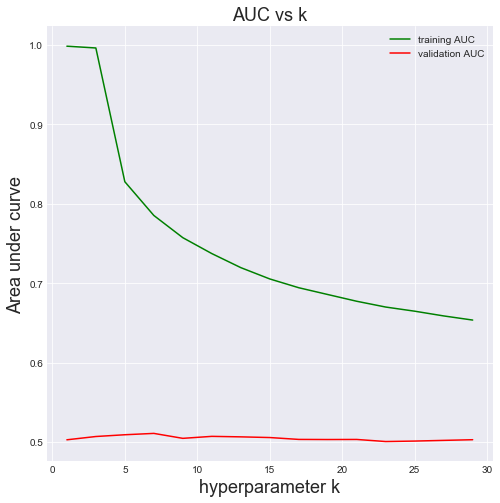

In [68]:
auc_max = max(cv_auc)
optimal_k = neighbors[cv_auc.index(auc_max)]
print('best hyperparameter is {} giving  auc of {} on cv data'.format(optimal_k,auc_max))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors,train_auc,'g',label = 'training AUC')
plt.plot(neighbors,cv_auc,'r',label='validation AUC')

plt.xlabel('hyperparameter k',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs k',fontsize=18)

#  AUC score

In [69]:
#finding the AUC of knn classiifer with optimal k on test data
print("*"*50)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn_optimal.fit(final_train_counts,Y_in)
pred = knn_optimal.predict(test_counts)
pred_train = []
pred_test = []
for i in range(0,final_train_counts.shape[0],1000):
    pred_train.append(knn_optimal.predict_proba(final_train_counts[i:i+1000])[:,1])
train_proba = np.hstack(pred_train)
for j in range(0,test_counts.shape[0],1000):
    pred_test.append(knn_optimal.predict_proba(test_counts[j:j+1000])[:,1])
test_proba = np.hstack(pred_test)
test_auc_brute_tfidf = roc_auc_score(Y_test,test_proba)
print('AUC on test data of knn classifier for k = {} is {}'.format(optimal_k,test_auc_brute_tfidf))

tfidf_brute_k = optimal_k

**************************************************
AUC on test data of knn classifier for k = 7 is 0.5085762795407295


# ROC curve

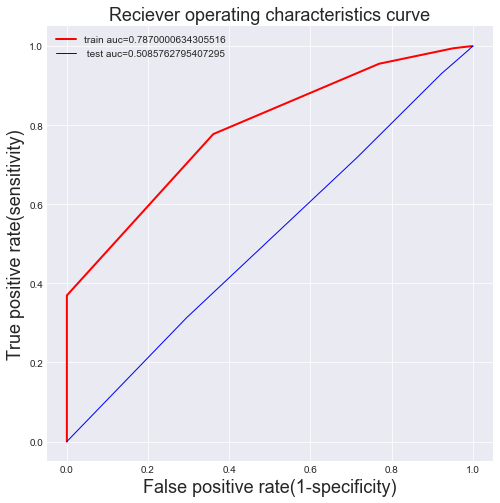

In [70]:
#plotting the ROC
fpr_tr, tpr_tr, _ = roc_curve(Y_in,train_proba)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_proba)
auc_train = roc_auc_score(Y_in,train_proba)
auc_test = roc_auc_score(Y_test, test_proba)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))

plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()


# Confusion matrix

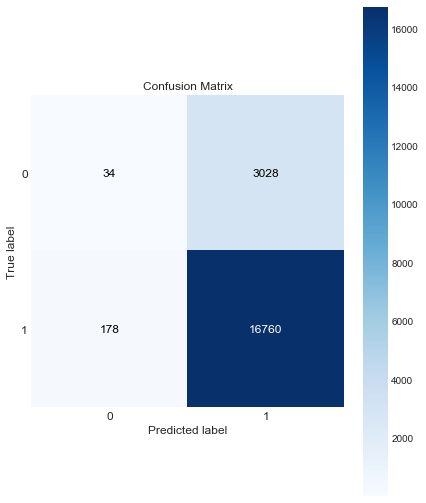

In [71]:
import scikitplot.metrics as skplt#using scikit-plot to directly get confusion matrix
skplt.plot_confusion_matrix(Y_test,pred,normalize=False,figsize=(7,9),text_fontsize='large')

# 4.2.2 Implementing KNN using Kd-tree

In [96]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)#limitting number of features
final_train_counts = tf_idf_vect.fit_transform(X_in).todense()[0:32000]
test_counts = tf_idf_vect.transform(X_test).todense()[0:8000]
train_counts = tf_idf_vect.fit_transform(X_train).todense()[0:25600]
cv_counts  = tf_idf_vect.transform(X_cv).todense()[0:6400]

print(cv_counts.shape)
print(train_counts.shape)
print(final_train_counts.shape)
print(test_counts.shape)


(6400, 500)
(25600, 500)
(32000, 500)
(8000, 500)


# Simple Cross validation

In [30]:
#*****************************************************cross validation ***********************************

neighbors = [i for i in range(1,30,2)]
train_auc = []
cv_auc = []



for i in (neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(train_counts,Y_train[0:25600])
    pred_tr = []
    for i in range(0,train_counts.shape[0],1600):
        pred_tr.append(knn.predict_proba(train_counts[i:i+1600])[:,1])
    pred_cv = []
    for j in range(0,cv_counts.shape[0],800):
        pred_cv.append(knn.predict_proba(cv_counts[j:j+800])[:,1])
    train_auc.append(roc_auc_score(Y_train[0:25600],np.hstack(pred_tr)))
    cv_auc.append(roc_auc_score(Y_cv[0:6400],np.hstack(pred_cv)))




# best hyperparameter

best hyperparameter is 25 giving  auc of 0.6035614225308737 on cv data


Text(0.5,1,'AUC vs k')

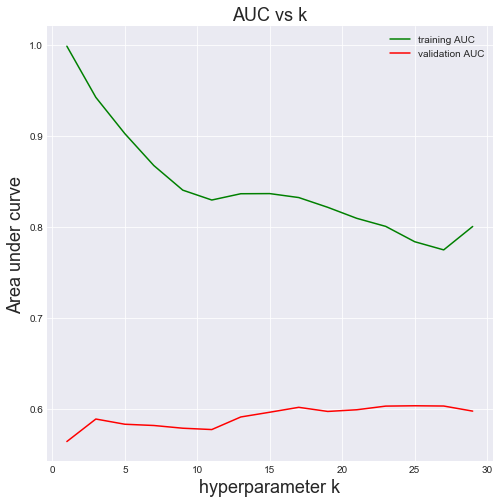

In [32]:
auc_max = max(cv_auc)
optimal_k = neighbors[cv_auc.index(auc_max)]
print('best hyperparameter is {} giving  auc of {} on cv data'.format(optimal_k,auc_max))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors,train_auc,'g',label = 'training AUC')
plt.plot(neighbors,cv_auc,'r',label='validation AUC')

plt.xlabel('hyperparameter k',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs k',fontsize=18)

#  AUC score

In [97]:
#finding the accuracy of knn classiifer with optimal k on test data
print("*"*50)
knn_optimal = KNeighborsClassifier(n_neighbors=25,algorithm='kd_tree')
knn_optimal.fit(final_train_counts,Y_in[0:32000])
pred = knn_optimal.predict(test_counts)
pred_train = []
pred_test = []
for i in range(0,final_train_counts.shape[0],1000):
    pred_train.append(knn_optimal.predict_proba(final_train_counts[i:i+1000])[:,1])
train_proba = np.hstack(pred_train)
for j in range(0,test_counts.shape[0],1000):
    pred_test.append(knn_optimal.predict_proba(test_counts[j:j+1000])[:,1])
test_proba = np.hstack(pred_test)
test_auc_kdtree_tfidf = roc_auc_score(Y_test[0:8000],test_proba)
print('AUC on test data of knn classifier for k = {} is {}'.format('25',test_auc_kdtree_tfidf))

tfidf_kdtree_k = optimal_k

**************************************************
AUC on test data of knn classifier for k = 25 is 0.559208470831996


# ROC curve

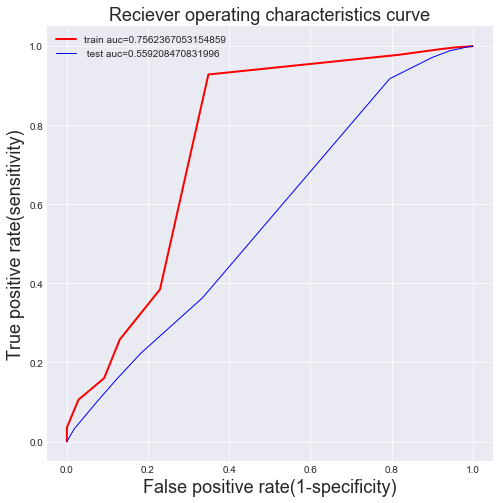

In [98]:
#plotting the ROC
fpr_tr, tpr_tr, _ = roc_curve(Y_in[0:32000],train_proba)
fpr_test, tpr_test, _ = roc_curve(Y_test[0:8000],test_proba)
auc_train = roc_auc_score(Y_in[0:32000],train_proba)
auc_test = roc_auc_score(Y_test[0:8000], test_proba)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))

plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()


# Confusion matrix

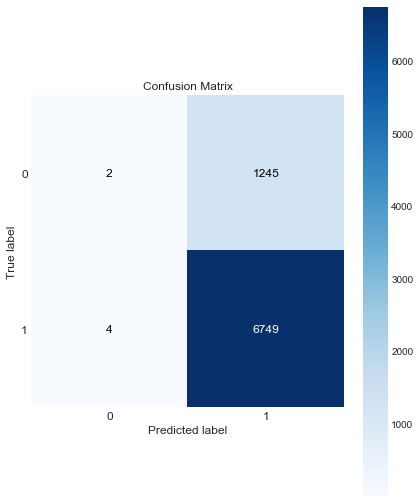

In [36]:
import scikitplot.metrics as skplt#using scikit-plot to directly get confusion matrix
skplt.plot_confusion_matrix(Y_test[0:8000],pred,normalize=False,figsize=(7,9),text_fontsize='large')

# 4.3 Word2Vec

# Vectorization

In [37]:
s_train = []
for sent in X_train:
    s_train.append(sent.split())
    
    
s_cv = []
for sent in X_cv:
    s_cv.append(sent.split())
    
s_test = []
for sent in X_test:
    s_test.append(sent.split())
    
s_final_train = []
for sent in X_in:
    s_final_train.append(sent.split())
    
    
w2v_model=Word2Vec(s_train,min_count=5,size=50, workers=4)#

w2v_words = list(w2v_model.wv.vocab)# min_count = 5 considers only words that occured atleast 5 times
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  15467


# 4.3.1 Average Word2Vec

# featurization

In [52]:
#***************************whole training data and test data*****************************************

# compute average word2vec for each review for X_train .
final_train_counts = []; 
for sent in s_final_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    final_train_counts.append(sent_vec)

print(len(final_train_counts))

# compute average word2vec for each review for X_test .
test_counts = []; 
for sent in s_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_counts.append(sent_vec)

print(len(test_counts))

80000
20000


In [53]:
#*************************************training and cross validation data******************************
train_counts = []; 
for sent in s_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_counts.append(sent_vec)
print(len(train_counts))


# compute average word2vec for each review for X_cv .
cv_counts = []; 
for sent in s_cv:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_counts.append(sent_vec)
print(len(cv_counts))

64000
16000


# 4.3.1.1 Implementing KNN using brute force

#  Simple Cross validation

In [43]:
#*****************************************************4 fold cross validation ***********************************

neighbors = [i for i in range(1,30,2)]
train_auc = []
cv_auc = []



for i in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_counts,Y_train)
    pred_tr = []
    for i in range(0,len(train_counts),1000): #doing bactch wise prediction
        pred_tr.append(knn.predict_proba(train_counts[i:i+1000])[:,1])#predicting on chunks of 1000 data points each time
    pred_cv = []
    for j in range(0,len(cv_counts),1000):
        pred_cv.append(knn.predict_proba(cv_counts[j:j+1000])[:,1])
    train_auc.append(roc_auc_score(Y_train,np.hstack(pred_tr)))
    cv_auc.append(roc_auc_score(Y_cv,np.hstack(pred_cv)))
    
    
    



100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [30:37<00:00, 124.25s/it]


best hyperparameter is 29 giving  auc of 0.8869002483242778 on cv data


Text(0.5,1,'AUC vs k')

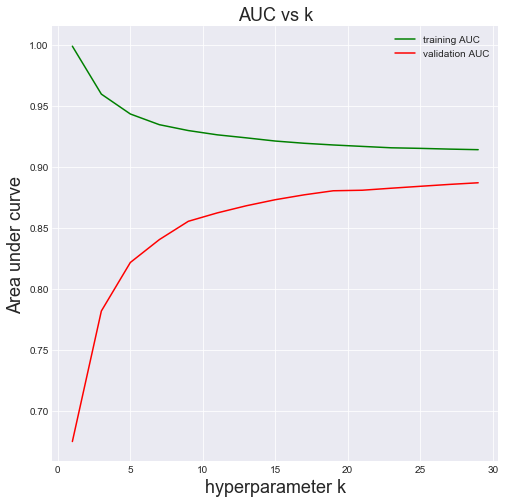

In [44]:
auc_max = max(cv_auc)
optimal_k = neighbors[cv_auc.index(auc_max)]
print('best hyperparameter is {} giving  auc of {} on cv data'.format(optimal_k,auc_max))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors,train_auc,'g',label = 'training AUC')
plt.plot(neighbors,cv_auc,'r',label='validation AUC')

plt.xlabel('hyperparameter k',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs k',fontsize=18)

#  AUC score

In [46]:

#finding the AUC of knn classiifer with optimal k on test data
print("*"*50)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='brute')
knn_optimal.fit(final_train_counts,Y_in)
pred = knn_optimal.predict(test_counts)
pred_train = []
pred_test = []
for i in range(0,len(final_train_counts),1000):
    pred_train.append(knn_optimal.predict_proba(final_train_counts[i:i+1000])[:,1])
train_proba = np.hstack(pred_train)
for j in range(0,len(test_counts),1000):
    pred_test.append(knn_optimal.predict_proba(test_counts[j:j+1000])[:,1])
test_proba = np.hstack(pred_test)
test_auc_brute_avgW2V = roc_auc_score(Y_test,test_proba)
print('AUC on test data of knn classifier for k = {} is {}'.format(optimal_k,test_auc_brute_avgW2V))

avgW2V_brute_k = optimal_k

**************************************************
AUC on test data of knn classifier for k = 29 is 0.8863332079490654


# ROC curve

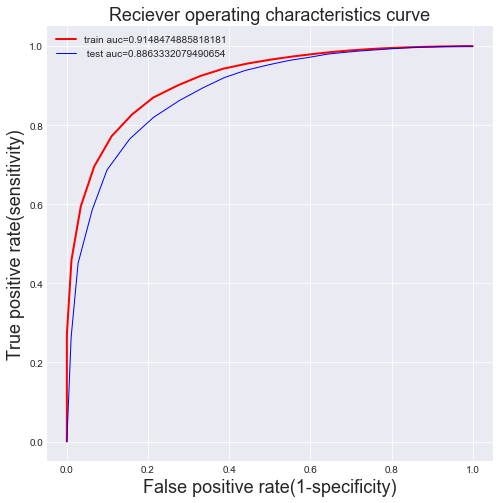

In [49]:
#plotting the ROC





fpr_tr, tpr_tr, _ = roc_curve(Y_in,train_proba)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_proba)
auc_train = roc_auc_score(Y_in,train_proba)
auc_test = roc_auc_score(Y_test, test_proba)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))

plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()
   

# Confusion matrix

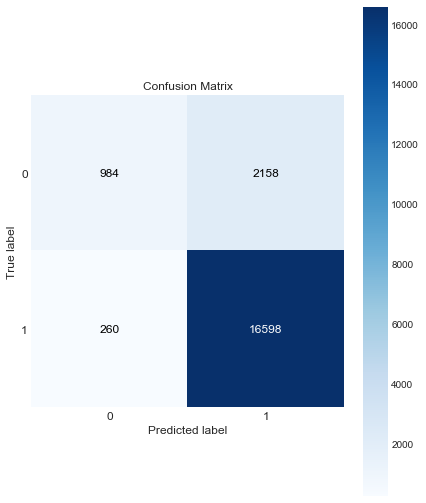

In [50]:
import scikitplot.metrics as skplt#using scikit-plot to directly get confusion matrix
skplt.plot_confusion_matrix(Y_test,pred,normalize=False,figsize=(7,9),text_fontsize='large')

# 4.3.1.2 Implementing KNN using Kd-tree

In [55]:
final_train_counts = final_train_counts[0:32000]
train_counts = train_counts[0:25600]
cv_counts = cv_counts[0:6400]
test_counts = test_counts[0:8000]

In [56]:
#*****************************************************4 fold cross validation ***********************************
neighbors = [i for i in range(1,30,2)]
train_auc = []
cv_auc = []



for i in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_counts,Y_train[0:25600])
    pred_tr = []
    for i in range(0,len(train_counts),1000): #doing bactch wise prediction
        pred_tr.append(knn.predict_proba(train_counts[i:i+1000])[:,1])#predicting on chunks of 1000 data points each time
    pred_cv = []
    for j in range(0,len(cv_counts),1000):
        pred_cv.append(knn.predict_proba(cv_counts[j:j+1000])[:,1])
    train_auc.append(roc_auc_score(Y_train[0:25600],np.hstack(pred_tr)))
    cv_auc.append(roc_auc_score(Y_cv[0:6400],np.hstack(pred_cv)))


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [05:27<00:00, 22.55s/it]


best hyperparameter is 29 giving  auc of 0.8895506803411783 on cv data


Text(0.5,1,'AUC vs k')

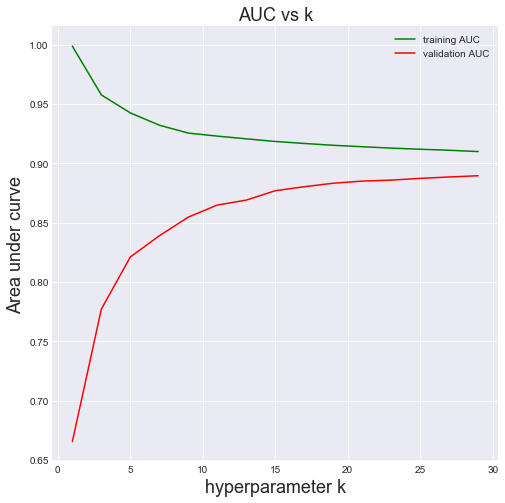

In [57]:
auc_max = max(cv_auc)
optimal_k = neighbors[cv_auc.index(auc_max)]
print('best hyperparameter is {} giving  auc of {} on cv data'.format(optimal_k,auc_max))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors,train_auc,'g',label = 'training AUC')
plt.plot(neighbors,cv_auc,'r',label='validation AUC')

plt.xlabel('hyperparameter k',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs k',fontsize=18)

#  AUC score

In [61]:
#finding the AUC of knn classiifer with optimal k on test data

print("*"*50)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_optimal.fit(final_train_counts,Y_in[0:32000])
pred = knn_optimal.predict(test_counts)
pred_train = []
pred_test = []
for i in range(0,len(final_train_counts),1000):
    pred_train.append(knn_optimal.predict_proba(final_train_counts[i:i+1000])[:,1])
train_proba = np.hstack(pred_train)
for j in range(0,len(test_counts),1000):
    pred_test.append(knn_optimal.predict_proba(test_counts[j:j+1000])[:,1])
test_proba = np.hstack(pred_test)
test_auc_kdtree_avgW2V = roc_auc_score(Y_test[0:8000],test_proba)
print('AUC on test data of knn classifier for k = {} is {}'.format(optimal_k,test_auc_kdtree_avgW2V))

avgW2V_kdtree_k = optimal_k

**************************************************
AUC on test data of knn classifier for k = 29 is 0.8786287742143413


# ROC curve

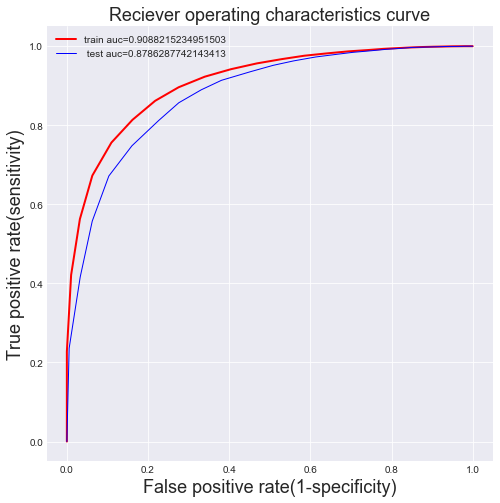

In [63]:
#plotting the ROC
fpr_tr, tpr_tr, _ = roc_curve(Y_in[0:32000],train_proba)
fpr_test, tpr_test, _ = roc_curve(Y_test[0:8000],test_proba)
auc_train = roc_auc_score(Y_in[0:32000],train_proba)
auc_test = roc_auc_score(Y_test[0:8000], test_proba)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))

plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()

   

# Confusion matrix

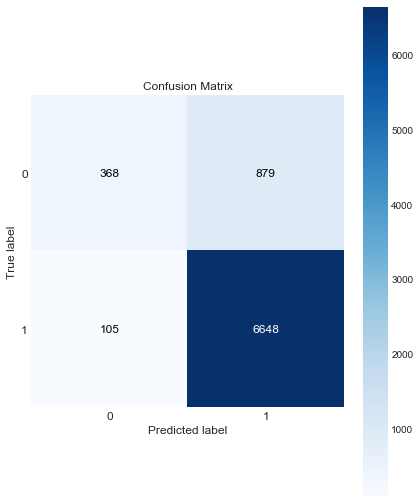

In [64]:
import scikitplot.metrics as skplt#using scikit-plot to directly get confusion matrix
skplt.plot_confusion_matrix(Y_test[0:8000],pred,normalize=False,figsize=(7,9),text_fontsize='large')

# 4.3.2 TfIdf Weighted Word2Vec

# featurization

In [65]:

model = TfidfVectorizer()
tf_idf1 = model.fit_transform(X_train)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [66]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names


train_counts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in s_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_counts.append(sent_vec)
    row += 1    
print(len(train_counts))

cv_counts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in s_cv: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_counts.append(sent_vec)
    row += 1
    
print(len(cv_counts))




64000
16000


In [67]:

final_train_counts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in s_final_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    final_train_counts.append(sent_vec)
    row += 1
    
print(len(final_train_counts)) 



test_counts = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in s_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_counts.append(sent_vec)
    row += 1
    
print(len(test_counts))

80000
20000


# 4.3.2.1 Implementing KNN using brute force

# Simple Cross Validation

In [77]:

neighbors = [i for i in range(1,30,2)]
train_auc = []
cv_auc = []

for i in (neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(train_counts,Y_train)
    pred_tr = []
    for i in range(0,len(train_counts),1000): #doing bactch wise prediction
        pred_tr.append(knn.predict_proba(train_counts[i:i+1000])[:,1])#predicting on chunks of 1000 data points each time
    pred_cv = []
    for j in range(0,len(cv_counts),1000):
        pred_cv.append(knn.predict_proba(cv_counts[j:j+1000])[:,1])
    train_auc.append(roc_auc_score(Y_train,np.hstack(pred_tr)))
    cv_auc.append(roc_auc_score(Y_cv,np.hstack(pred_cv)))

best hyperparameter is 9 giving  auc of 0.501121981906878 on cv data


Text(0.5,1,'AUC vs k')

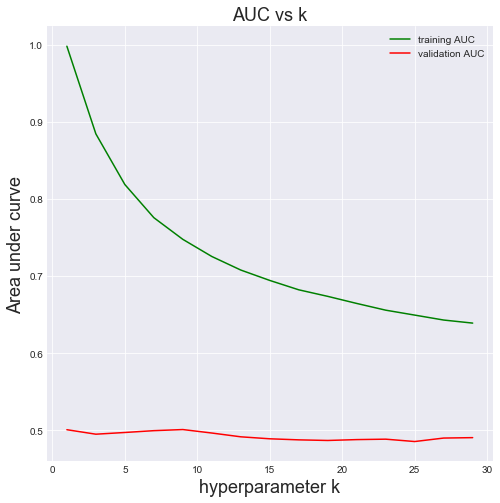

In [78]:
auc_max = max(cv_auc)
optimal_k = neighbors[cv_auc.index(auc_max)]
print('best hyperparameter is {} giving  auc of {} on cv data'.format(optimal_k,auc_max))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors,train_auc,'g',label = 'training AUC')
plt.plot(neighbors,cv_auc,'r',label='validation AUC')
plt.xlabel('hyperparameter k',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs k',fontsize=18)

#  AUC score

In [79]:
#finding the AUC of knn classiifer with optimal k on test data
#finding the AUC of knn classiifer with optimal k on test data
print("*"*50)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_optimal.fit(final_train_counts,Y_in[0:32000])
pred = knn_optimal.predict(test_counts)
pred_train = []
pred_test = []
for i in range(0,len(final_train_counts),1000):
    pred_train.append(knn_optimal.predict_proba(final_train_counts[i:i+1000])[:,1])
train_proba = np.hstack(pred_train)
for j in range(0,len(test_counts),1000):
    pred_test.append(knn_optimal.predict_proba(test_counts[j:j+1000])[:,1])
test_proba = np.hstack(pred_test)
test_auc_brute_tiW2V = roc_auc_score(Y_test,test_proba)
print('AUC on test data of knn classifier for k = {} is {}'.format(optimal_k,test_auc_brute_tiW2V))

tiW2V_brute_k = optimal_k

**************************************************
AUC on test data of knn classifier for k = 9 is 0.8158877776316932


# ROC curve

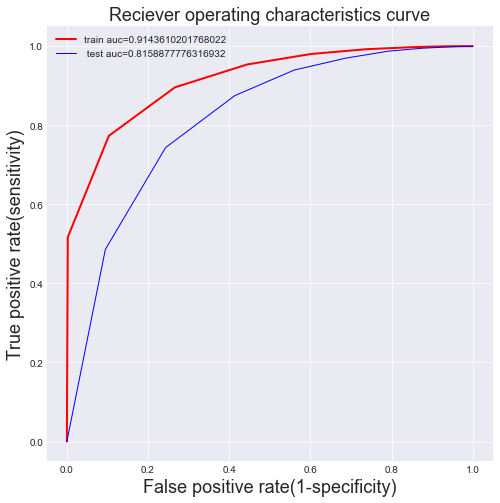

In [80]:
#plotting the ROC
fpr_tr, tpr_tr, _ = roc_curve(Y_in,train_proba)
fpr_test, tpr_test, _ = roc_curve(Y_test,test_proba)
auc_train = roc_auc_score(Y_in,train_proba)
auc_test = roc_auc_score(Y_test, test_proba)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))

plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()

# Confusion matrix

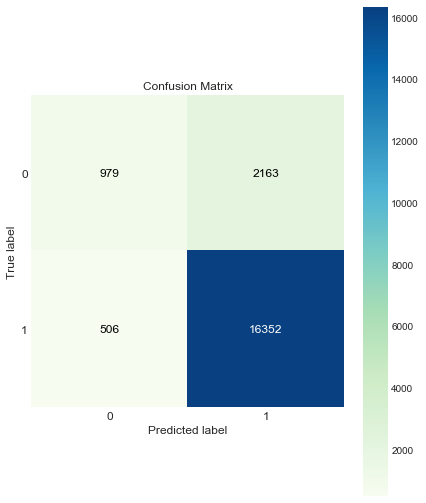

In [81]:
import scikitplot.metrics as skplt#using scikit-plot to directly get confusion matrix
skplt.plot_confusion_matrix(Y_test,pred,normalize=False,figsize=(7,9),text_fontsize='large',cmap = 'GnBu')

# 4.3.2.2 Implementing KNN using kd-tree

In [83]:
final_train_counts = final_train_counts[0:32000]
train_counts = train_counts[0:25600]
cv_counts = cv_counts[0:6400]
test_counts = test_counts[0:8000]

In [86]:
neighbors = [i for i in range(1,30,2)]
train_auc = []
cv_auc = []

for i in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(train_counts,Y_train[0:25600])
    pred_tr = []
    for i in range(0,len(train_counts),1000): #doing bactch wise prediction
        pred_tr.append(knn.predict_proba(train_counts[i:i+1000])[:,1])#predicting on chunks of 1000 data points each time
    pred_cv = []
    for j in range(0,len(cv_counts),1000):
        pred_cv.append(knn.predict_proba(cv_counts[j:j+1000])[:,1])
    train_auc.append(roc_auc_score(Y_train[0:25600],np.hstack(pred_tr)))
    cv_auc.append(roc_auc_score(Y_cv[0:6400],np.hstack(pred_cv)))



  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

  7%|█████▌                                                                             | 1/15 [00:23<05:22, 23.00s/it]

 13%|███████████                                                                        | 2/15 [02:13<10:39, 49.23s/it]

 20%|████████████████▌                                                                  | 3/15 [04:07<13:42, 68.54s/it]

 27%|██████████████████████▏                                                            | 4/15 [06:02<15:10, 82.76s/it]

 33%|███████████████████████████▋                                                       | 5/15 [08:00<15:32, 93.25s/it]

 40%|████████████████████████████████▊                                                 | 6/15 [09:59<15:08, 100.90s/it]

 47%|██████████████████████████████████████▎                                           | 7/15 [11:59<14:13, 106.66s/it]

 53%|█████████████████████████

best hyperparameter is 5 giving  auc of 0.507172404252052 on cv data


Text(0.5,1,'AUC vs k')

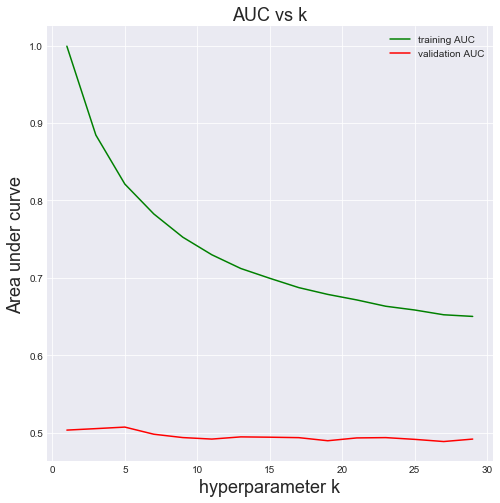

In [87]:
auc_max = max(cv_auc)
optimal_k = neighbors[cv_auc.index(auc_max)]
print('best hyperparameter is {} giving  auc of {} on cv data'.format(optimal_k,auc_max))
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(neighbors,train_auc,'g',label = 'training AUC')
plt.plot(neighbors,cv_auc,'r',label='validation AUC')
plt.xlabel('hyperparameter k',fontsize=18)
plt.ylabel('Area under curve',fontsize=18)
plt.legend(loc = 'best')
plt.title('AUC vs k',fontsize=18)

#  AUC score

In [88]:
#finding the AUC of knn classiifer with optimal k on test data
print("*"*50)
print("*"*50)
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn_optimal.fit(final_train_counts,Y_in[0:32000])
pred = knn_optimal.predict(test_counts)
pred_train = []
pred_test = []
for i in range(0,len(final_train_counts),1000):
    pred_train.append(knn_optimal.predict_proba(final_train_counts[i:i+1000])[:,1])
train_proba = np.hstack(pred_train)
for j in range(0,len(test_counts),1000):
    pred_test.append(knn_optimal.predict_proba(test_counts[j:j+1000])[:,1])
test_proba = np.hstack(pred_test)
test_auc_kdtree_tiW2V = roc_auc_score(Y_test[0:8000],test_proba)
print('AUC on test data of knn classifier for k = {} is {}'.format(optimal_k,test_auc_kdtree_tiW2V))


tiW2V_kdtree_k = optimal_k

**************************************************
**************************************************
AUC on test data of knn classifier for k = 5 is 0.7813068556895502


# ROC curve

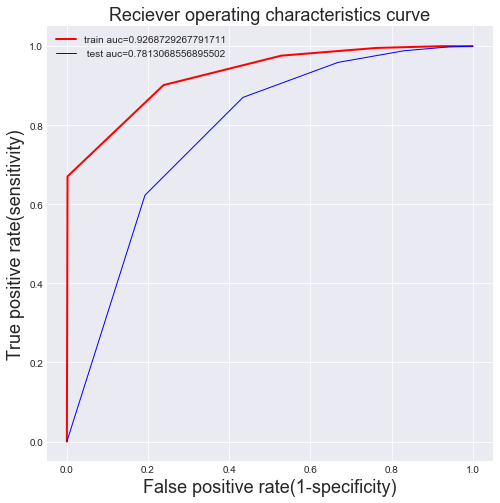

In [89]:
#plotting the ROC
fpr_tr, tpr_tr, _ = roc_curve(Y_in[0:32000],train_proba)
fpr_test, tpr_test, _ = roc_curve(Y_test[0:8000],test_proba)
auc_train = roc_auc_score(Y_in[0:32000],train_proba)
auc_test = roc_auc_score(Y_test[0:8000], test_proba)
sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
plt.plot(fpr_tr,tpr_tr,'r',linewidth=2,label="train auc="+str(auc_train))
plt.plot(fpr_test,tpr_test,'b',linewidth=1,label=" test auc="+str(auc_test))
plt.xlabel('False positive rate(1-specificity)',fontsize=18)
plt.ylabel('True positive rate(sensitivity)',fontsize=18)
plt.title('Reciever operating characteristics curve',fontsize=18)
plt.legend(loc='best')
plt.show()

# Confusion matrix

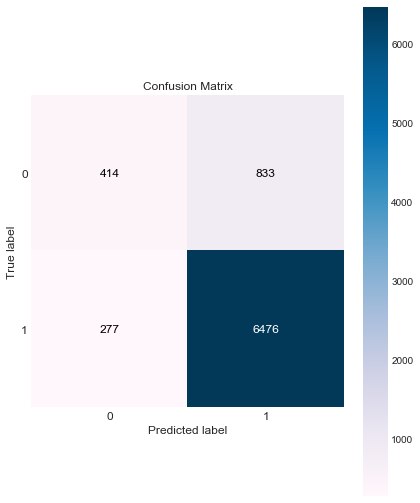

In [90]:
import scikitplot.metrics as skplt#using scikit-plot to directly get confusion matrix
skplt.plot_confusion_matrix(Y_test[0:8000],pred,normalize=False,figsize=(7,9),text_fontsize='large',cmap = 'PuBu')

# Conclusion

In [95]:
from prettytable import PrettyTable


x = PrettyTable()



x.field_names = ["featurization", "Algorithm", "best hyperparameter(k)", 'AUC']

x.add_row(["Bag of Vectors", "brute force", '25', '0.7011771868031555'])
x.add_row(["TF-IDF", "brute force", '7','0.5085762795407295'])
x.add_row(["Avg-W2V", "brute force", avgW2V_brute_k, test_auc_brute_avgW2V])
x.add_row(["Tfidf-W2V", "brute force", tiW2V_brute_k, test_auc_brute_tiW2V])
x.add_row(["Bag of Vectors", "Kd-tree", '21', '0.7599637553163726'])
x.add_row(["TF-IDF", "kd-tree", tfidf_kdtree_k,test_auc_kdtree_tfidf])
x.add_row(["Avg-W2V", "kd-tree", avgW2V_kdtree_k, test_auc_kdtree_avgW2V])
x.add_row(["Tfidf-W2V", "kd-tree",tiW2V_kdtree_k,test_auc_kdtree_tiW2V])


print(x)

+----------------+-------------+------------------------+--------------------+
| featurization  |  Algorithm  | best hyperparameter(k) |        AUC         |
+----------------+-------------+------------------------+--------------------+
| Bag of Vectors | brute force |           25           | 0.7011771868031555 |
|     TF-IDF     | brute force |           7            | 0.5085762795407295 |
|    Avg-W2V     | brute force |           29           | 0.8863332079490654 |
|   Tfidf-W2V    | brute force |           9            | 0.8158877776316932 |
| Bag of Vectors |   Kd-tree   |           21           | 0.7599637553163726 |
|     TF-IDF     |   kd-tree   |           25           | 0.559208470831996  |
|    Avg-W2V     |   kd-tree   |           29           | 0.8786287742143413 |
|   Tfidf-W2V    |   kd-tree   |           5            | 0.7813068556895502 |
+----------------+-------------+------------------------+--------------------+


# NOTE: 40k points for kd-tree and 100k for brute-force were considered

* a highly imbalanced dataset with majority positive classes
* Because of this AUC was choosen as metric.
* we get best AUC in average word to vector featurization on applying brute force and kd-tree respectively